In [2]:
import cv2
import matplotlib.pyplot as plt
import ast
from tqdm.notebook import tqdm
import csv
import random
import hashlib
import numpy as np
import os
from operator import itemgetter 
from os import listdir
from os.path import isfile, join
import pandas as pd
import json

DIR_PATH = '/Users/alexdrozdz/Desktop/Studia/00. Seminarium magisterskie/'

In [3]:
# get metadata 
file = open(DIR_PATH + "Master_degree/additional_data/bw_website_data.json", "r")

metadata = json.load(file)

In [4]:
metadata

{'data': [{'id': '6057f064021d110001000d63',
   'location': {'standard': 'http://s3.amazonaws.com/ndnp-jpeg-surrogates/uuml_julich_ver01/data/sn85058396/print/1918101601/0168.jpg'},
   'region': {'toolName': 'rectangleTool',
    'color': '#fe0000',
    'x': 125.38053097345133,
    'y': 839.5013318834625,
    'width': 1820.7433628318583,
    'height': 2714.751060246522,
    'label': 'Illustration/Photo'},
   'width': 6776,
   'height': 9336,
   'meta_data': {'set_key': 'http://chroniclingamerica.loc.gov/lccn/sn85058396/1918-10-16/ed-1/seq-3/',
    'subject_url': 'http://chroniclingamerica.loc.gov/lccn/sn85058396/1918-10-16/ed-1/seq-3/',
    'subject_description': 'The Ogden standard. October 16, 1918. Page 3',
    'resize': '1.000000',
    'alto': 'http://s3.amazonaws.com/ndnp-batches/uuml_julich_ver01/data/sn85058396/print/1918101601/0168.xml'},
   'data': {'caption': 'HERE\'S NEW GOWN THAT SAVES COAL\nTo save coal-put on more clothes, ladles!\nHere\'s the new fuel-saving dress-and wor

In [3]:
url_list = []
for i in range(len(metadata['data'])):
    url_list.append(metadata['data'][i]['location']['standard'])
    
url_list = list(dict.fromkeys(url_list))

In [4]:
# train test split
set_names = [
    " ".join(url_list[i].split('/')[-4:]).replace(' ', '_') for i in range(len(url_list))
]

In [5]:
def calcMD5Hash(name, split):
    return int(hashlib.md5(str(name).encode('Utf-8')).digest()[-1]) <= split * 256

In [6]:
train_test_hash_list = list(pd.Series(set_names).apply(lambda x: calcMD5Hash(x, 0.8)))

In [7]:
train_names1, test_names = [], []

for i in range(len(train_test_hash_list)):
    if train_test_hash_list[i] == True:
        train_names1.append(set_names[i])
    elif train_test_hash_list[i] == False:
        test_names.append(set_names[i])

In [8]:
train_val_hash_list = list(pd.Series(train_names1).apply(lambda x: calcMD5Hash(x, 0.08)))

In [9]:
train_names, val_names = [], []

for i in range(len(train_val_hash_list)):
    if train_val_hash_list[i] == True:
        val_names.append(train_names1[i])
    elif train_val_hash_list[i] == False:
        train_names.append(train_names1[i])

In [10]:
len(train_names), len(test_names), len(val_names)

(3666, 1032, 406)

In [11]:
cats, ps, x0s, y0s, x1s, y1s = [], [], [], [], [], []

for i in tqdm(range(len(metadata['data']))):
    try:
        try:
            cat = metadata['data'][i]['data']['category']
        except:
            cat = metadata['data'][i]['data']['values'][0]['category']
    except:
        print(f'Label for photo number: {i} not found, photo skipped')
        continue
    
    if cat == 'Photograph':
        cat = 0
    elif cat == 'Illustration':
        cat = 1
    elif cat == 'Map':
        cat = 2
    elif cat == 'Comics/Cartoon':
        cat = 3
    elif cat == 'Editorial Cartoon':
        cat = 4
    elif cat == 'Headline':
        cat = 5
    elif cat == 'Advertisement':
        cat = 6
        
    cats.append(cat)
    
    ps.append(" ".join(metadata['data'][i]['location']['standard'].split('/')[-4:]).replace(' ', '_'))
    
    x0s.append(int(float(metadata['data'][i]['region']['x'])))
    y0s.append(int(float(metadata['data'][i]['region']['y'])))
    x1s.append(int(float(metadata['data'][i]['region']['x']) + float(metadata['data'][i]['region']['width'])))
    y1s.append(int(float(metadata['data'][i]['region']['y']) + float(metadata['data'][i]['region']['height'])))

Label for photo number: 1 not found, photo skipped
Label for photo number: 6 not found, photo skipped
Label for photo number: 9 not found, photo skipped
Label for photo number: 14 not found, photo skipped
Label for photo number: 22 not found, photo skipped
Label for photo number: 24 not found, photo skipped
Label for photo number: 30 not found, photo skipped
Label for photo number: 51 not found, photo skipped
Label for photo number: 254 not found, photo skipped
Label for photo number: 369 not found, photo skipped
Label for photo number: 407 not found, photo skipped
Label for photo number: 1217 not found, photo skipped
Label for photo number: 1576 not found, photo skipped
Label for photo number: 2248 not found, photo skipped
Label for photo number: 6554 not found, photo skipped
Label for photo number: 7535 not found, photo skipped
Label for photo number: 7904 not found, photo skipped
Label for photo number: 8108 not found, photo skipped
Label for photo number: 8117 not found, photo skip

In [12]:
no_duplicated_names = list(dict.fromkeys(ps))

In [13]:
len(no_duplicated_names)

5090

In [14]:
list_of_indexes_lists = []
for name in no_duplicated_names:
    list_of_indexes_lists.append([i for i, e in enumerate(ps) if e == name])

In [15]:
multi_elem_list = []
names_list = []
for j, i in enumerate(list_of_indexes_lists):
    temp_list = []
    names_list.append(no_duplicated_names[j])
    for e in range(len(i)):
        temp_list.append(f'{cats[i[e]]}/{x0s[i[e]]},{y0s[i[e]]},{x1s[i[e]]},{y1s[i[e]]}/{30}')
    
    multi_elem_list.append(temp_list)

In [16]:
new_train_set, new_test_set, new_val_set = [], [], []
train_name_list, test_name_list, val_name_list = [], [], []

for i, name in enumerate(names_list):
    if name in train_names:
        train_name_list.append(name)
        new_train_set.append(multi_elem_list[i])
    elif name in test_names:
        test_name_list.append(name)
        new_test_set.append(multi_elem_list[i])
    elif name in val_names:
        val_name_list.append(name)
        new_val_set.append(multi_elem_list[i])
    else:
        print(f"{name} doesn't exist in any set")

In [17]:
len(new_train_set), len(new_test_set), len(new_val_set)

(3657, 1027, 406)

In [18]:
len(train_name_list), len(test_name_list), len(val_name_list)

(3657, 1027, 406)

In [19]:
# check if every file is correct
scraped_photos = [
    f for f in listdir(DIR_PATH + 'scraped_photos_more_data/') if isfile(join(DIR_PATH + 'scraped_photos_more_data/', f))
]

scraped_photos.remove('.DS_Store')

In [20]:
check_list = train_name_list + test_name_list + val_name_list

good, bad = [], []
for i in check_list:
    if i in scraped_photos:
        good.append(1)
    else:
        bad.append(1)
        
print(f'Number of matched photos: {sum(good)}')
print(f'Number of not matched photos: {sum(bad)}')
print(f'Number of missing metadata compared to data set: {len(scraped_photos) - len(check_list)}')

Number of matched photos: 5090
Number of not matched photos: 0
Number of missing metadata compared to data set: 132


In [21]:
def show_random_img(names_list, coordinates_list, path_to_photos):
    random_img = random.randint(0,len(names_list))
    print(names_list[random_img])
    random_adnotation = random.randint(0,len(coordinates_list[random_img])-1)
    variables = coordinates_list[random_img][random_adnotation].split('/')
    coordinates = variables[1].split(',')
    x0, y0 = coordinates[0], coordinates[1]
    x1, y1 = coordinates[2], coordinates[3]

    box = cv2.rectangle(
        cv2.imread(
            path_to_photos + names_list[random_img]
        ),
        (int(x0), int(y0)), 
        (int(x1), int(y1)), 
        (0, 255, 0), 
        thickness=10, 
    )

    fig, ax = plt.subplots(figsize=(15, 10))
    ax.imshow(box, cmap='gray')

sn88085187_00211108459_1917052601_0188.jpg


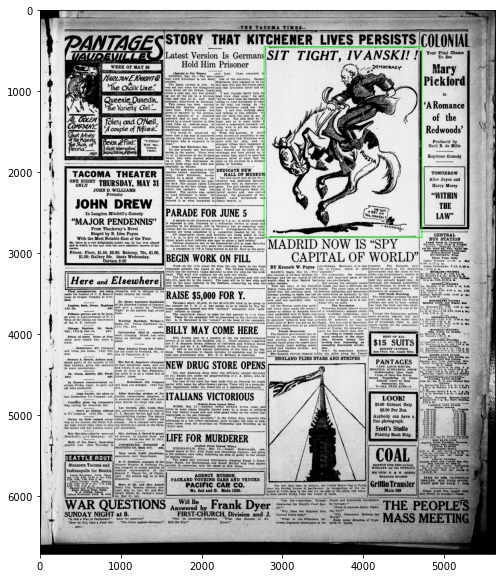

In [22]:
show_random_img(
    names_list = train_name_list + test_name_list + val_name_list,
    coordinates_list = new_train_set + new_test_set + new_val_set,
    path_to_photos = DIR_PATH + 'scraped_photos_more_data/',
)

In [23]:
def final_input_transformer(input_list):
    final_list = []
    for i in range(len(input_list)):
        final_list.append(";".join(input_list[i]))
        
    return final_list

In [24]:
final_train_set = final_input_transformer(new_train_set)
final_test_set = final_input_transformer(new_test_set)
final_val_set = final_input_transformer(new_val_set)

In [25]:
# categories distribution
categories = []

for i in final_train_set:
    splitted = i.split(';')
    if len(splitted) > 1:
        for e in splitted:
            categories.append(e.split('/')[0])
    else:
        categories.append(i.split('/')[0])
    
for i in final_test_set:
    splitted = i.split(';')
    if len(splitted) > 1:
        for e in splitted:
            categories.append(e.split('/')[0])
    else:
        categories.append(i.split('/')[0])
    
for i in final_val_set:
    splitted = i.split(';')
    if len(splitted) > 1:
        for e in splitted:
            categories.append(e.split('/')[0])
    else:
        categories.append(i.split('/')[0])
    
cat_series = pd.Series(categories)

cat_series = cat_series.map({
    '0': 'fotografia', 
    '1': 'ilustracja',
    '2': 'mapa', 
    '3': 'komiks/karykatura',
    '4': 'karykatura polityczna', 
    '5': 'nagłówek',
    '6': 'reklama',
})

cat_series.value_counts()

fotografia               6130
komiks/karykatura        1849
ilustracja               1665
karykatura polityczna     448
mapa                      118
dtype: int64

In [26]:
# save files in final shape
def save_list_to_tsv_file(path, output_list):
    with open(path, 'w', newline='') as f_output:
        tsv_output = csv.writer(f_output, delimiter='\t')
        tsv_output.writerow(output_list)

In [29]:
# train:
save_list_to_tsv_file(DIR_PATH + 'Master_gonito/train/expected.tsv', final_train_set)
save_list_to_tsv_file(DIR_PATH + 'Master_gonito/train/in.tsv', train_name_list)

# test:
save_list_to_tsv_file(DIR_PATH + 'Master_gonito/test-A/expected.tsv', final_test_set)
save_list_to_tsv_file(DIR_PATH + 'Master_gonito/test-A/in.tsv', test_name_list)

# val:
save_list_to_tsv_file(DIR_PATH + 'Master_gonito/dev-0/expected.tsv', final_val_set)
save_list_to_tsv_file(DIR_PATH + 'Master_gonito/dev-0/in.tsv', val_name_list)